 Partie 1 : Exploration des donneès

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import scikitplot
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

1.1 : Chargemenet des donneès

In [8]:

# Charger un fichier CSV
data = pd.read_csv('fer2013.csv')
print(data.head())  # Pour voir les premières lignes


   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


2.2 : exploration des donnees 

In [4]:
print(data.shape)  # Dimensions des données
print(data.dtypes)   # Type des variables


(35887, 3)
emotion     int64
pixels     object
Usage      object
dtype: object


In [9]:
print(data['emotion'].value_counts())  # Compte les images par classe


emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


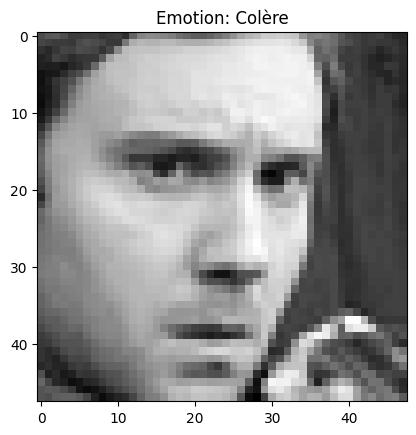

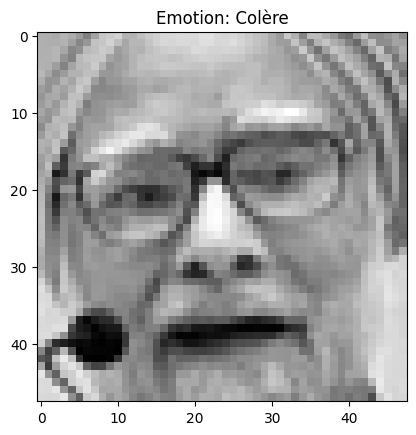

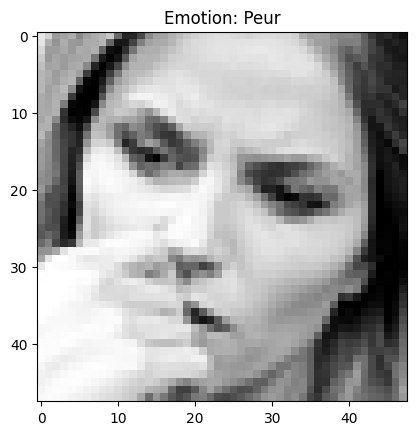

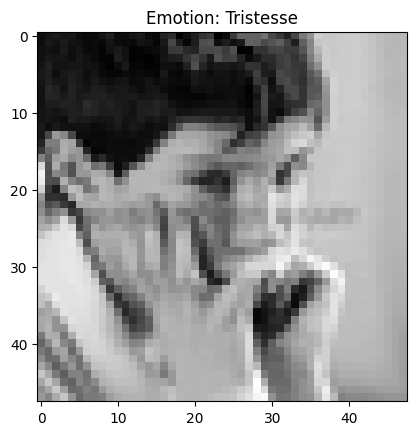

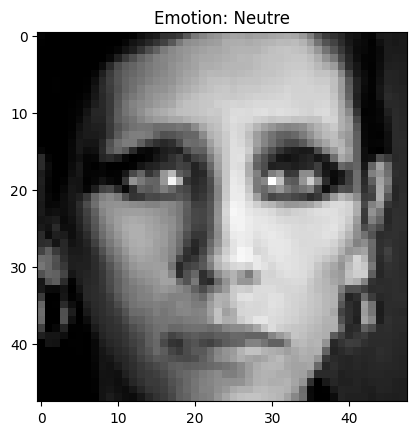

In [11]:


# Fonction pour convertir une chaîne de pixels en image 48x48
def convert_pixels_to_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')  # Convertir la chaîne en tableau numpy
    image = pixels.reshape(48, 48)  # Redimensionner en 48x48
    return image

# Visualiser quelques exemples d'images avec leurs émotions
def plot_sample_images(data, num_samples=5):
    emotions = ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre']  # Modifier selon les labels d'émotion
    for i in range(num_samples):
        img = convert_pixels_to_image(data['pixels'].iloc[i])
        emotion_label = int(data['emotion'].iloc[i])  # Récupérer l'émotion
        plt.imshow(img, cmap='gray')
        plt.title(f"Emotion: {emotions[emotion_label]}")
        plt.show()

# Visualiser 5 exemples d'images
plot_sample_images(data, num_samples=5)


Partie 2 : Pretraitement des donnees 

2.1 : Normalisation des Images

In [12]:
# Normaliser les pixels des images (de 0 à 255 -> 0 à 1)
def normalize_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')
    return pixels / 255.0  # Normalisation des valeurs


2.2 encodage des labels

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encodage des étiquettes (si elles ne sont pas déjà codées)
encoder = LabelEncoder()
data['emotion'] = encoder.fit_transform(data['emotion'])
print(encoder.classes_)  # Vérifie les étiquettes


[0 1 2 3 4 5 6]


2.3 separation de donnees en ensembles d entrainement et validation 

In [14]:
from sklearn.model_selection import train_test_split

# Extraire les images et les étiquettes
X = np.array([normalize_image(pixels) for pixels in data['pixels']])
y = data['emotion'].values

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier les dimensions des ensembles
print(f"Ensemble d'entraînement : {X_train.shape}, Ensemble de test : {X_test.shape}")


Ensemble d'entraînement : (28709, 2304), Ensemble de test : (7178, 2304)


Partie 3 : Construction du model

3.1 : definition du modele 

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Définir le modèle CNN
model = Sequential()

# Première couche de convolution et de pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Deuxième couche de convolution et de pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Troisième couche de convolution et de pooling
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplatir et ajouter des couches entièrement connectées
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Pour éviter le surapprentissage
model.add(Dense(7, activation='softmax'))  # 7 classes d'émotions

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

3.2 : entrainement du model 

In [14]:
# Redéfinir le modèle si nécessaire
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définition du modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # Supposant qu'il y a 7 classes d'émotions
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Refaire l'entraînement
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/50
449/449 [==============================] - 23s 50ms/step - loss: 1.5948 - accuracy: 0.3788 - val_loss: 1.4686 - val_accuracy: 0.4363
Epoch 2/50
449/449 [==============================] - 21s 47ms/step - loss: 1.3767 - accuracy: 0.4764 - val_loss: 1.3606 - val_accuracy: 0.4838
Epoch 3/50
449/449 [==============================] - 22s 49ms/step - loss: 1.2737 - accuracy: 0.5142 - val_loss: 1.3426 - val_accuracy: 0.4898
Epoch 4/50
449/449 [==============================] - 21s 47ms/step - loss: 1.1912 - accuracy: 0.5478 - val_loss: 1.2931 - val_accuracy: 0.5125
Epoch 5/50
449/449 [==============================] - 21s 46ms/step - loss: 1.1008 - accuracy: 0.5830 - val_loss: 1.2507 - val_accuracy: 0.5279
Epoch 6/50
449/449 [==============================] - 21s 46ms/step - loss: 1.0173 - accuracy: 0.6177 - val_loss: 1.2509 - val_accuracy: 0.5386
Epoch 7/50
449/449 [==============================] - 21s 47ms/step - loss: 0.9290 - accuracy: 0.6541 - val_loss: 1.2519 - val_accuracy:

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [17]:
# Sauvegarder le modèle
model.save('emotion_recognition_model.h5')


In [15]:
from tensorflow.keras.models import load_model
# Charger le modèle sauvegardé
model = load_model('emotion_recognition_model.h5')

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Appliquer l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajuster le taux d'apprentissage si nécessaire
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reprendre l'entraînement avec les données augmentées
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_test, y_test),
                    epochs=50)


Epoch 1/50
449/449 [==============================] - 26s 55ms/step - loss: 1.8313 - accuracy: 0.2455 - val_loss: 1.7750 - val_accuracy: 0.2593
Epoch 2/50
449/449 [==============================] - 25s 56ms/step - loss: 1.7698 - accuracy: 0.2755 - val_loss: 1.6990 - val_accuracy: 0.3298
Epoch 3/50
449/449 [==============================] - 25s 55ms/step - loss: 1.7276 - accuracy: 0.3082 - val_loss: 1.6674 - val_accuracy: 0.3553
Epoch 4/50
449/449 [==============================] - 25s 55ms/step - loss: 1.6972 - accuracy: 0.3255 - val_loss: 1.6178 - val_accuracy: 0.3742
Epoch 5/50
449/449 [==============================] - 24s 53ms/step - loss: 1.6625 - accuracy: 0.3447 - val_loss: 1.5667 - val_accuracy: 0.3962
Epoch 6/50
449/449 [==============================] - 24s 53ms/step - loss: 1.6373 - accuracy: 0.3605 - val_loss: 1.5314 - val_accuracy: 0.4100
Epoch 7/50
449/449 [==============================] - 24s 54ms/step - loss: 1.6154 - accuracy: 0.3692 - val_loss: 1.5054 - val_accuracy:

Partie 4 : èvaluation du model 

4.1 : visualisation de la courbe d apprentissage 

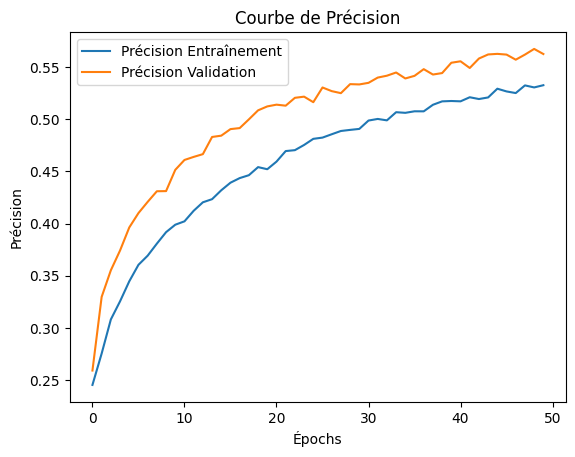

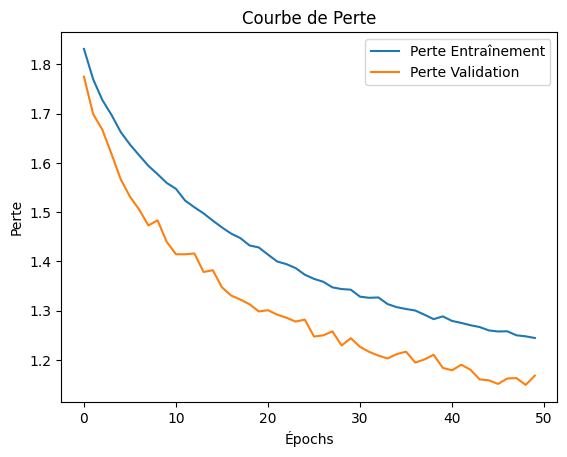

In [22]:


# Afficher la courbe de précision
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Afficher la courbe de perte
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()
plt.show()


4.2 : matric de confusion 

225/225 [==============================] - 2s 9ms/step


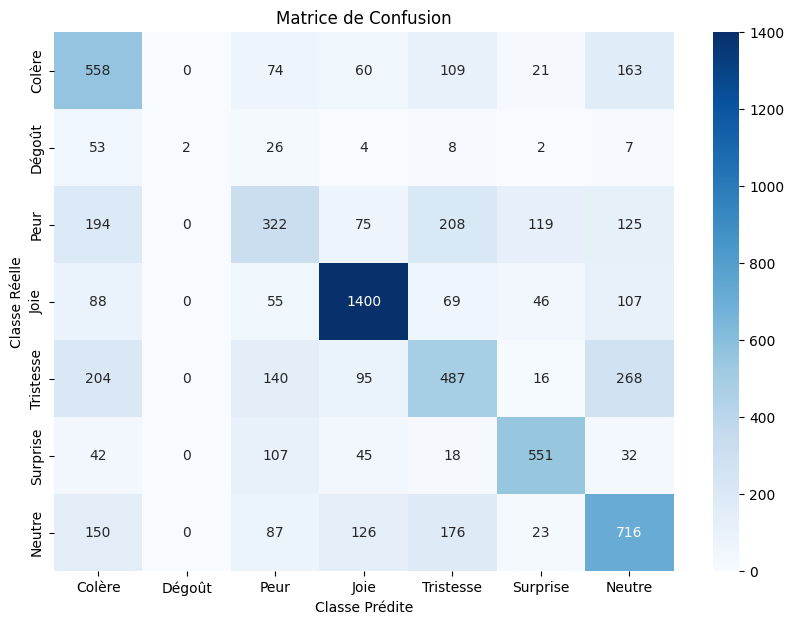

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Obtenir les classes prédites

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Définir les noms des classes
class_names = ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre']

# Afficher la matrice de confusion avec les noms des classes
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()


4.3 : rapport de classification 

In [26]:
from sklearn.metrics import classification_report

# Définir les noms des classes
class_names = ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre']

# Obtenir le rapport de classification avec les noms des classes
class_report = classification_report(y_test, y_pred_classes, target_names=class_names)
print("Rapport de Classification :\n", class_report)


Rapport de Classification :
               precision    recall  f1-score   support

      Colère       0.43      0.57      0.49       985
      Dégoût       1.00      0.02      0.04       102
        Peur       0.40      0.31      0.35      1043
        Joie       0.78      0.79      0.78      1765
   Tristesse       0.45      0.40      0.43      1210
    Surprise       0.71      0.69      0.70       795
      Neutre       0.50      0.56      0.53      1278

    accuracy                           0.56      7178
   macro avg       0.61      0.48      0.47      7178
weighted avg       0.57      0.56      0.56      7178



partie 5 : test et implementation 

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Définir la fonction de prédiction sur une nouvelle image
def predict_emotion(model, img_path, class_names):
    # Charger l'image
    img = image.load_img(img_path, target_size=(48, 48), color_mode="grayscale")
    
    # Convertir l'image en tableau numpy
    img_array = image.img_to_array(img)
    
    # Redimensionner pour correspondre à la taille d'entrée attendue par le modèle
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normaliser les pixels (si vous l'avez fait pendant l'entraînement, par exemple en divisant par 255)
    img_array /= 255.0
    
    # Effectuer la prédiction
    predictions = model.predict(img_array)
    
    # Obtenir la classe prédite
    predicted_class = np.argmax(predictions[0])
    
    # Afficher le nom de la classe prédite
    print(f"L'émotion prédite est: {class_names[predicted_class]}")




In [30]:
# Utilisation de la fonction pour prédire une émotion
img_path = 'image1.png'
class_names = ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre']
predict_emotion(model, img_path, class_names)

1/1 [==============================] - 0s 19ms/step
L'émotion prédite est: Colère
